In [2]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm as cmaps
import healpy as hp
from tqdm.notebook import tqdm
import torch
import torch.nn as nn

from scipy.stats import chi2
from scipy.stats import norm

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *
from theory.limit import get_lim

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from plot_params import params
import matplotlib.pylab as pylab

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

alpha_plot = 1.
lw_plot = 2.5

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsha


## Basline analysis

In [10]:
# from sbi.neural_nets.flow import build_made
from sbi.neural_nets.classifier import build_mlp_mixed_classifier
import mlflow

run_id = '1936d60ac8f945b4b6873c96a4946f32'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-astrometry/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

In [11]:
Sigma_q = 1e8 / (4 * np.pi)
pixarea = hp.nside2pixarea(nside=64, degrees=False)
N_q_pix = Sigma_q * pixarea

In [12]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

In [13]:
list(density_estimator.children())[0].add_noise.sigma = 0.

In [14]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
    """
    def __init__(self, sigma=0.):
        super().__init__()
        self.sigma = sigma
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.sigma != 0.:
            sampled_noise = self.noise.expand(*x.size()).detach().float().normal_() * self.sigma
            x = x + sampled_noise
        return x 

In [15]:
n_trials = 100  # Number of samples to simulate
n_test = 30  # Number of points in f_sub over which to compute likelihood ratio

out = np.zeros((n_trials, n_test))

for i_trial in tqdm(range(n_trials)):
    
    # Simulate subhalos and make astrometric map
    sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150., alpha=-1.9)
    sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
    sim.set_subhalo_properties(sim.c200_SCP, distdep=False)
    
    sim.analysis_pipeline(get_sample=True)
    sim.mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T
    
    x_test = torch.Tensor(sim.mu_qsrs)
    
    # Add noise
    gn = GaussianNoise(sigma=0.0023)
    x_test = gn(x_test).T
    
    theta_test = torch.linspace(1., 300., n_test).unsqueeze(1)

    # Compute LLR over the parameter grid
    out[i_trial, :] = [density_estimator(x_test.unsqueeze(0), theta_test[i].unsqueeze(0)).squeeze().detach().numpy() \
           for i in (range(n_test))]

  0%|          | 0/100 [00:00<?, ?it/s]

Simulating 1227 subhalos between 7.0 and 10.0


Simulating 1195 subhalos between 7.0 and 10.0
Simulating 1182 subhalos between 7.0 and 10.0
Simulating 1273 subhalos between 7.0 and 10.0
Simulating 1265 subhalos between 7.0 and 10.0
Simulating 1208 subhalos between 7.0 and 10.0
Simulating 1208 subhalos between 7.0 and 10.0
Simulating 1200 subhalos between 7.0 and 10.0
Simulating 1237 subhalos between 7.0 and 10.0
Simulating 1122 subhalos between 7.0 and 10.0
Simulating 1195 subhalos between 7.0 and 10.0
Simulating 1191 subhalos between 7.0 and 10.0
Simulating 1194 subhalos between 7.0 and 10.0
Simulating 1246 subhalos between 7.0 and 10.0
Simulating 1287 subhalos between 7.0 and 10.0
Simulating 1163 subhalos between 7.0 and 10.0
Simulating 1216 subhalos between 7.0 and 10.0
Simulating 1177 subhalos between 7.0 and 10.0
Simulating 1231 subhalos between 7.0 and 10.0
Simulating 1268 subhalos between 7.0 and 10.0
Simulating 1229 subhalos between 7.0 and 10.0
Simulating 1165 subhalos between 7.0 and 10.0
Simulating 1208 subhalos between 7

In [ ]:
# s = 1 / (1 + np.exp(-out))  # Sigmoid projection
# out_mean = np.mean(np.log(s / (1 - s)), axis=0)

In [16]:
out_mean = np.mean(out, axis=0)

In [102]:
out_mean

array([-2.94414675, -2.487873  , -2.05343777, -1.63955597, -1.25567784,
       -0.90872966, -0.6046571 , -0.34277256, -0.11850638,  0.06791678,
        0.2230499 ,  0.3462319 ,  0.43393137,  0.481338  ,  0.49853136,
        0.5019778 ,  0.47577225,  0.41847568,  0.33321665,  0.21900476,
        0.0810652 , -0.08247891, -0.27132437, -0.48420727, -0.72035422,
       -0.98269118, -1.27120722, -1.57788548, -1.8973031 , -2.23001369])

### Compute power spectra

In [17]:
from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

In [18]:
# Precompute some number for NFW and Burkert
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

In [19]:
# Calculate spectra for fiducial CDM

pspecpop = PowerSpectraPopulations(l_max=2000)

pspecpop.set_radial_distribution(pspecpop.r2rho_V_ein_EAQ, R_min=1e-3*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e7*M_s, M_max=1e10*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1.1e10*M_s, N_calib=150, alpha=-1.9)
pspecpop.set_subhalo_properties(pspecpop.c200_SCP)

C_l_mu = pspecpop.get_C_l_total_ary();

  0%|          | 0/50 [00:00<?, ?it/s]

### Compute variation in sensitivity with different noise levels

In [20]:
run_id_list = ['303ceae8593c4ab78a573e1a3b1d83b1', '1936d60ac8f945b4b6873c96a4946f32', 'ede8a36abe9d4baf9dd8bbfbf7d0f158']

n_trials = 50
n_test = 30

lims_ary = np.zeros((len(run_id_list), n_trials))

for i_run, run_id in enumerate(run_id_list):

    data_dir = '/scratch/sm8383/sbi-fermi/data/'
    model_uri = "runs:/{}/density_estimator".format(run_id)
    density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-astrometry/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

    list(density_estimator.children())[0].add_noise.sigma = 0.


    out = np.zeros((n_trials, n_test))

    for i_trial in tqdm(range(n_trials)):

        sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150., alpha=-1.9)
        sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
        sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

        sim.analysis_pipeline(get_sample=True)
        sim.mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T

        x_test = torch.Tensor(sim.mu_qsrs)

        gn = GaussianNoise(sigma=0.0023)
        x_test = gn(x_test).T

        theta_test = torch.linspace(1., 300., n_test).unsqueeze(1)

        out[i_trial, :] = [density_estimator(x_test.unsqueeze(0), theta_test
                                             [i].unsqueeze(0)).squeeze().detach().numpy() \
               for i in (range(n_test))]

    llrmin, llrmax = 0., 15.

    for i_trial, out_inst in enumerate(out):
        llr = - 2 * out_inst
        llr -= np.min(llr)
        llr = np.clip(llr, llrmin, llrmax)

        try:
            lim_trial = get_lim(np.expand_dims(llr[:], 0), theta_test.squeeze().detach().numpy()[:])
        except:
            lim_trial = np.nan
            continue
        
        lims_ary[i_run, i_trial] = lim_trial

  0%|          | 0/50 [00:00<?, ?it/s]

Simulating 1173 subhalos between 7.0 and 10.0


Simulating 1167 subhalos between 7.0 and 10.0
Simulating 1171 subhalos between 7.0 and 10.0
Simulating 1207 subhalos between 7.0 and 10.0
Simulating 1222 subhalos between 7.0 and 10.0
Simulating 1265 subhalos between 7.0 and 10.0
Simulating 1234 subhalos between 7.0 and 10.0
Simulating 1223 subhalos between 7.0 and 10.0
Simulating 1192 subhalos between 7.0 and 10.0
Simulating 1257 subhalos between 7.0 and 10.0
Simulating 1196 subhalos between 7.0 and 10.0
Simulating 1185 subhalos between 7.0 and 10.0
Simulating 1182 subhalos between 7.0 and 10.0
Simulating 1211 subhalos between 7.0 and 10.0
Simulating 1262 subhalos between 7.0 and 10.0
Simulating 1169 subhalos between 7.0 and 10.0
Simulating 1181 subhalos between 7.0 and 10.0
Simulating 1197 subhalos between 7.0 and 10.0
Simulating 1218 subhalos between 7.0 and 10.0
Simulating 1179 subhalos between 7.0 and 10.0
Simulating 1227 subhalos between 7.0 and 10.0
Simulating 1210 subhalos between 7.0 and 10.0
Simulating 1225 subhalos between 7

  0%|          | 0/50 [00:00<?, ?it/s]

Simulating 1240 subhalos between 7.0 and 10.0
Simulating 1162 subhalos between 7.0 and 10.0
Simulating 1281 subhalos between 7.0 and 10.0
Simulating 1231 subhalos between 7.0 and 10.0
Simulating 1180 subhalos between 7.0 and 10.0
Simulating 1183 subhalos between 7.0 and 10.0
Simulating 1249 subhalos between 7.0 and 10.0
Simulating 1159 subhalos between 7.0 and 10.0
Simulating 1258 subhalos between 7.0 and 10.0
Simulating 1251 subhalos between 7.0 and 10.0
Simulating 1186 subhalos between 7.0 and 10.0
Simulating 1083 subhalos between 7.0 and 10.0
Simulating 1186 subhalos between 7.0 and 10.0
Simulating 1173 subhalos between 7.0 and 10.0
Simulating 1199 subhalos between 7.0 and 10.0
Simulating 1160 subhalos between 7.0 and 10.0
Simulating 1230 subhalos between 7.0 and 10.0
Simulating 1244 subhalos between 7.0 and 10.0
Simulating 1173 subhalos between 7.0 and 10.0
Simulating 1200 subhalos between 7.0 and 10.0
Simulating 1163 subhalos between 7.0 and 10.0
Simulating 1243 subhalos between 7

  0%|          | 0/50 [00:00<?, ?it/s]

Simulating 1255 subhalos between 7.0 and 10.0
Simulating 1212 subhalos between 7.0 and 10.0
Simulating 1213 subhalos between 7.0 and 10.0
Simulating 1205 subhalos between 7.0 and 10.0
Simulating 1203 subhalos between 7.0 and 10.0
Simulating 1275 subhalos between 7.0 and 10.0
Simulating 1170 subhalos between 7.0 and 10.0
Simulating 1214 subhalos between 7.0 and 10.0
Simulating 1264 subhalos between 7.0 and 10.0
Simulating 1208 subhalos between 7.0 and 10.0
Simulating 1242 subhalos between 7.0 and 10.0
Simulating 1157 subhalos between 7.0 and 10.0
Simulating 1296 subhalos between 7.0 and 10.0
Simulating 1199 subhalos between 7.0 and 10.0
Simulating 1202 subhalos between 7.0 and 10.0
Simulating 1211 subhalos between 7.0 and 10.0
Simulating 1252 subhalos between 7.0 and 10.0
Simulating 1223 subhalos between 7.0 and 10.0
Simulating 1142 subhalos between 7.0 and 10.0
Simulating 1208 subhalos between 7.0 and 10.0
Simulating 1193 subhalos between 7.0 and 10.0
Simulating 1245 subhalos between 7

In [21]:
lims_ary[lims_ary == 0.] = np.nan

### Plot

0.1280184991297499
0.2153241974261756


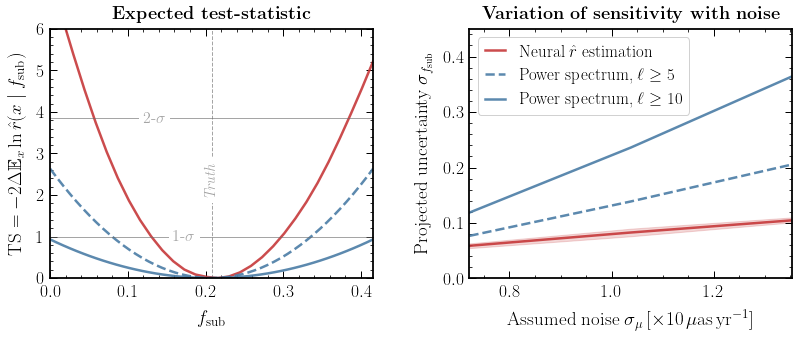

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(11.2, 4.8))

## TS profiles

# Fisher forecast setup

sigma_mu = .1
sigma_alpha = None
N_q = 1e8

fDM_base = 1
dfDM_base = 0.1

Cl_ary_fid = pspecpop.C_l_ary*fDM_base

p = pspecpop.C_l_ary*(fDM_base + dfDM_base)
m = pspecpop.C_l_ary*(fDM_base - dfDM_base)

fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, None, None, '$\\f_\mathrm{DM}$' )

M_calib_ary = np.logspace(8, 10) * M_s
calib = 150 / np.trapz(pspecpop.rho_M_SI(M_calib_ary, alpha=-1.9), M_calib_ary)

M_ary = np.logspace(-6, 10) * M_s
f_sub_fid = np.trapz(M_ary * calib * pspecpop.rho_M_SI(M_ary, alpha=-1.9), M_ary) / M_MW

signal = np.linspace(1e-3, 2, 100)

ls_list = ['--', '-']

llrmin, llrmax = 0., 15.

llr = - 2 * out_mean
llr -= np.min(llr)
llr = np.clip(llr, llrmin, llrmax)

# Plot TS profile obtained by neural LR estimation
ax[0].plot((f_sub_fid / 150) * theta_test.squeeze().detach().numpy(), llr, label="SBI", color=cols_default[0])

# Get fisher 1-sigma uncertainty for different multipole thresholds
# the plot the respective TS profiles

for i_l, l_min in enumerate([5, 10]):

    parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
    observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=l_min, l_max_mu=300, l_min_alpha=200, l_max_alpha=2000)

    fshr = FisherForecast(parameters, observation)

    sigma=fshr.pars_vary[0].sigma

    x_arr=np.linspace(0, 2)
    LL_ary = norm.logpdf(x_arr, fDM_base, sigma)
    ax[0].plot(f_sub_fid * x_arr, -2 * (LL_ary - np.max(LL_ary)), label=r"PS, $\ell \geq {}$".format(l_min), ls=ls_list[i_l], color=cols_default[1])
    
    print(fshr.pars_vary[0].sigma * f_sub_fid)

# Significance thresholds

ax[0].axhline(chi2.isf(1 - .95, 1), color='dimgrey', alpha=0.6, lw=1)
t = ax[0].text(f_sub_fid / 3 + 0.05, chi2.isf(1 - .95, 1), r"2-$\sigma$",  color='dimgrey', alpha=0.6, fontsize=16, verticalalignment='center')
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

ax[0].axhline(chi2.isf(1 - .68, 1), color='dimgrey', alpha=0.6, lw=1)
t = ax[0].text(f_sub_fid / (3 / 2) + 0.02, chi2.isf(1 - .68, 1), r"1-$\sigma$",  color='dimgrey', alpha=0.6, fontsize=16, verticalalignment='center')
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

ax[0].axvline(f_sub_fid, color='dimgrey', lw=1, ls='--', alpha=0.6)
t = ax[0].text(f_sub_fid, 2, r"\emph{Truth}", rotation=90, horizontalalignment='center', fontsize=15, color='dimgrey', alpha=0.6)
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

ax[0].set_ylim(-0.01, 6)
ax[0].set_xlim(0.0, 0.415)

ax[0].set_xlabel(r"$f_\mathrm{sub}$")
ax[0].set_ylabel(r"$\mathrm{TS}  = -2 \Delta \mathbb{E}_x\ln  \hat r(x\mid f_\mathrm{sub}) $")

ax[0].set_title(r"\bf{Expected test-statistic}", y=1.008)

sigma_list = [0.0016, 0.0023, 0.003]

# l_min_list = [2, 5, 10]
l_min_list = [5, 10]

sigma_ps = np.zeros((len(l_min_list), len(sigma_list)))

for i_l, l_min in enumerate(l_min_list):
    for i_s, sigma_mu in enumerate([0.0721, 0.105, 0.132]):    

        N_q = 1e8

        parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
        observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=l_min, l_max_mu=3 * nside - 1, l_min_alpha=200, l_max_alpha=2000)

        fshr = FisherForecast(parameters, observation)

        sigma=fshr.pars_vary[0].sigma
        sigma_ps[i_l, i_s] = (f_sub_fid * sigma)

run_id_list = ['303ceae8593c4ab78a573e1a3b1d83b1', '1936d60ac8f945b4b6873c96a4946f32', 'ede8a36abe9d4baf9dd8bbfbf7d0f158']

perc = (f_sub_fid / 150 / 2) * np.array([np.nanpercentile(lims_ary[i], q=[2.5, 16, 50, 84, 97.5]) for i in range(len(run_id_list))])

ax[1].plot(np.array(sigma_list) * 10 * np.sqrt(N_q_pix), perc[:, 2], label="Neural $\hat r$ estimation", color=cols_default[0])
# ax[1].fill_between(np.array(sigma_list) * 10 * np.sqrt(N_q_pix), perc[:, 1], perc[:, 3], alpha=0.2, color=cols_default[0])
ax[1].fill_between(np.array(sigma_list) * 10 * np.sqrt(N_q_pix), perc[:, 0], perc[:, 4], alpha=0.2, color=cols_default[0])

for i_s, sigma_mu in enumerate(sigma_ps):
    ax[1].plot(np.array(sigma_list) * 10 * np.sqrt(N_q_pix), sigma_mu, label=r"Power spectrum, $\ell \ge {}$".format(l_min_list[i_s]), color=cols_default[1], ls=ls_list[i_s])
    
ax[1].set_xlim(0.0016 * 10 * np.sqrt(N_q_pix), 0.003 * 10 * np.sqrt(N_q_pix))
ax[1].set_ylim(0, 0.45)

ax[1].set_xlabel(r"Assumed noise $\sigma_\mu\,[\times 10\,\mu$as\,yr$^{-1}$]")
ax[1].set_ylabel(r"Projected uncertainty $\sigma_{f_\mathrm{sub}}$")

ax[1].set_title(r"\bf{Variation of sensitivity with noise}", y=1.008)

ax[1].legend(frameon=True, framealpha=0.90, handlelength=1.2, loc='upper left')

plt.tight_layout()
fig.subplots_adjust(wspace=0.3)
plt.savefig("../paper/arXiv-v1/figures/results.pdf")

## Correlated noise tests

In [23]:
lmax = 64 * 3 - 1
l_ary = np.arange(lmax)

In [24]:
run_id = '1936d60ac8f945b4b6873c96a4946f32'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-astrometry/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

In [25]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

In [26]:
list(density_estimator.children())[0].add_noise.sigma = 0.

In [27]:
n_trials = 100
n_test = 30

out = np.zeros((n_trials, n_test))

for i_trial in tqdm(range(n_trials)):
    
    sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150., alpha=-1.9)
    sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
    sim.set_subhalo_properties(sim.c200_SCP, distdep=False)
    
    sim.analysis_pipeline(get_sample=True)
    sim.mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T
    
    x_test = torch.Tensor(sim.mu_qsrs)
    
    lmax = 64 * 3 - 1
    
    sigma=0.0023

    # Simulate correlated noise
    input_cl = sigma ** 2 * hp.nside2pixarea(64, degrees=False) * (10 - 9 / (1 + np.exp(-(-10 + l_ary) / 1.)))
    noise_test = torch.Tensor([hp.synfast(input_cl, nside=64, pixwin=True), hp.synfast(input_cl, nside=64, pixwin=True)])
    
    x_test = (x_test.T + noise_test)
    
    theta_test = torch.linspace(1., 300., n_test).unsqueeze(1)

    out[i_trial, :] = [density_estimator(x_test.unsqueeze(0), theta_test
                                         [i].unsqueeze(0)).squeeze().detach().numpy() \
           for i in (range(n_test))]

  0%|          | 0/100 [00:00<?, ?it/s]

Simulating 1204 subhalos between 7.0 and 10.0


Simulating 1242 subhalos between 7.0 and 10.0
Simulating 1191 subhalos between 7.0 and 10.0
Simulating 1168 subhalos between 7.0 and 10.0
Simulating 1209 subhalos between 7.0 and 10.0
Simulating 1241 subhalos between 7.0 and 10.0
Simulating 1162 subhalos between 7.0 and 10.0
Simulating 1188 subhalos between 7.0 and 10.0
Simulating 1228 subhalos between 7.0 and 10.0
Simulating 1263 subhalos between 7.0 and 10.0
Simulating 1190 subhalos between 7.0 and 10.0
Simulating 1221 subhalos between 7.0 and 10.0
Simulating 1210 subhalos between 7.0 and 10.0
Simulating 1228 subhalos between 7.0 and 10.0
Simulating 1179 subhalos between 7.0 and 10.0
Simulating 1203 subhalos between 7.0 and 10.0
Simulating 1240 subhalos between 7.0 and 10.0
Simulating 1200 subhalos between 7.0 and 10.0
Simulating 1203 subhalos between 7.0 and 10.0
Simulating 1149 subhalos between 7.0 and 10.0
Simulating 1207 subhalos between 7.0 and 10.0
Simulating 1187 subhalos between 7.0 and 10.0
Simulating 1168 subhalos between 7

In [29]:
out_mean_lsnoise = np.mean(out, axis=0)

### Plot

In [34]:
import matplotlib

params= {'text.latex.preamble' : [r'\usepackage{amssymb}']}
matplotlib.rcParams.update(params)

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


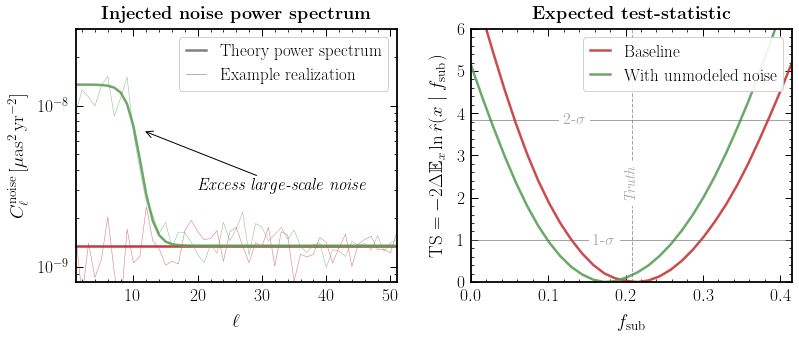

In [38]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 2, figsize=(11.2, 4.8))

llrmin, llrmax = 0., 15.

llr_lsnoise = - 2 * out_mean_lsnoise
llr_lsnoise -= np.min(llr_lsnoise)
llr_lsnoise = np.clip(llr_lsnoise, llrmin, llrmax)

llr = - 2 * out_mean
llr -= np.min(llr)
llr = np.clip(llr, llrmin, llrmax)

## TS profile for both cases

ax[1].plot((f_sub_fid / 150) * theta_test.squeeze().detach().numpy(), llr, color=cols_default[0], label="Baseline")
ax[1].plot((f_sub_fid / 150) * theta_test.squeeze().detach().numpy(), llr_lsnoise, color=cols_default[2], label="With unmodeled noise")

from scipy.interpolate import interp1d

# Do a cheeky interpolation for the smallest parameter points that weren't explored
x_interp = np.linspace(0, ((f_sub_fid / 150) * theta_test.squeeze().detach().numpy())[0] - 1e-3, 10)
sp_interp = interp1d((f_sub_fid / 150) * theta_test.squeeze().detach().numpy(), llr_lsnoise, bounds_error=False, fill_value="extrapolate")

ax[1].plot(x_interp, sp_interp(x_interp), color=cols_default[2], )

ax[1].axhline(chi2.isf(1 - .95, 1), color='dimgrey', alpha=0.6, lw=1)
t = ax[1].text(f_sub_fid / 3 + 0.05, chi2.isf(1 - .95, 1), r"2-$\sigma$",  color='dimgrey', alpha=0.6, fontsize=16, verticalalignment='center')
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

ax[1].axhline(chi2.isf(1 - .68, 1), color='dimgrey', alpha=0.6, lw=1)
t = ax[1].text(f_sub_fid / (3 / 2) + 0.02, chi2.isf(1 - .68, 1), r"1-$\sigma$",  color='dimgrey', alpha=0.6, fontsize=16, verticalalignment='center')
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

ax[1].axvline(f_sub_fid, color='dimgrey', lw=1, ls='--', alpha=0.6)
t = ax[1].text(f_sub_fid, 2, r"\emph{Truth}", rotation=90, horizontalalignment='center', fontsize=15, color='dimgrey', alpha=0.6)
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

ax[1].set_ylim(-0.01, 6)
ax[1].set_xlim(0.0, 0.415)

ax[1].set_xlabel(r"$f_\mathrm{sub}$")
ax[1].set_ylabel(r"$\mathrm{TS}  = -2 \Delta \mathbb{E}_x\ln  \hat r(x\mid f_\mathrm{sub}) $")
# ax[1].set_ylabel(r"$\mathrm{TS}  = -2 \ln  (\hat r / \hat r_\mathrm{max}) $")

ax[1].set_title(r"\bf{Expected test-statistic}", y=1.008)

ax[1].legend(loc='upper right', frameon=True, framealpha=0.9, handlelength=1.2)

## Illustration of noise model

sigma = 0.0023
    
ax[0].axhline(sigma ** 2 * hp.nside2pixarea(64, degrees=False), color=cols_default[0], ls='-', label="Baseline")

input_cl = sigma ** 2 * hp.nside2pixarea(64, degrees=False) * np.ones_like(l_ary)
for _ in range(1):
    synmap = hp.synfast(input_cl, nside=64)
    ax[0].plot(hp.anafast(synmap), color=cols_default[0], alpha=0.6, lw=0.6)

# Theory noise power spectrum
input_cl = sigma ** 2 * hp.nside2pixarea(64, degrees=False) * (10 - 9 / (1 + np.exp(-(-10 + l_ary) / 1.)))

ax[0].plot(l_ary, input_cl, color=cols_default[2], ls='-', label="Excess large-scale noise",)

# Create and plot an example realization
for _ in range(1):
    synmap = hp.synfast(input_cl, nside=64)
    ax[0].plot(hp.anafast(synmap), color=cols_default[2], alpha=0.6, lw=0.6)

ax[0].set_yscale("log")

ax[0].set_xlim(1, 51)
ax[0].set_ylim(8e-10, 3e-8)

ax[0].set_xlabel(r"$\ell$")
ax[0].set_ylabel(r"$C_\ell^\mathrm{noise}\,[\mu\mathrm{as}^2\,\mathrm{yr}^{-2}]$")
ax[0].set_title(r"\bf{Injected noise power spectrum}", y=1.008)

ax[0].annotate(r"\emph{Excess large-scale noise}", (11.5, 7e-9), xytext=(20, 3e-9), fontsize=17, arrowprops=dict(facecolor='black', arrowstyle='->'))

# Custom legend
legend_elements = [Line2D([0], [0], color='grey', lw=2.5, label='Theory power spectrum'),
                   Line2D([0], [0], color='grey', lw=0.6, label='Example realization')]

ax[0].legend(handles=legend_elements, loc='upper right', frameon=True, framealpha=0.9, handlelength=1.2)

plt.tight_layout()
fig.subplots_adjust(wspace=0.23)
plt.savefig("../paper/arXiv-v1//figures/lowell_noise.pdf")